In [230]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import weather_and_time_functions as weather_time

In [231]:
pd.set_option('display.max_columns',None)
scaler = StandardScaler()

flight_df = pd.read_feather('data/v2_clean_flight')
flight_test_df = pd.read_feather('data/v1_clean_flight_test')
fuel_consumption_df = pd.read_feather('data/v1_clean_fuel_consumption')
passenger_df = pd.read_feather('data/v1_clean_passenger')

In [232]:
# def duration_to_rank(x):
#     if x == 'short':
#         return 0
#     elif x =='medium':
#         return 1
#     else:
#         return 2

# flight_df['flight_duration'] = flight_df['flight_duration'].apply(lambda x: duration_to_rank(x))
## Not significant to the final model of features. 

In [233]:
dep_hour = weather_time.obtain_depart_hour(flight_df)
arr_hour = weather_time.obtain_arrival_hour(flight_df)
flight_df['dep_hour'] = dep_hour
flight_df['arr_hour'] = arr_hour
flight_df.drop('hour',axis=1,inplace=True)

In [234]:
flight_df['day'] = pd.to_datetime(flight_df['fl_date'],yearfirst=True).dt.day
flight_df['month'] = flight_df['month'].astype(int)
flight_df['dep_hour'] = flight_df['dep_hour'].astype(int)
flight_df['arr_hour'] = flight_df['arr_hour'].astype(int)

In [235]:
num_cols = ['crs_elapsed_time','distance','month','arr_hour']
cat_cols = ['origin','dest','op_unique_carrier']
y_target = flight_df['arr_delay'].fillna(0)
flight_model = flight_df[['crs_elapsed_time','distance','month','arr_hour','origin','dest','op_unique_carrier']]

In [236]:
one_hot = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

In [237]:
transformed_data = one_hot.fit_transform(flight_model[cat_cols])
encoded_data = pd.DataFrame(transformed_data, index=flight_model[cat_cols].index)
final_flight_model = pd.concat([flight_model,encoded_data],axis=1)
final_flight_model.drop(['origin','dest','op_unique_carrier'],axis=1,inplace=True)

In [238]:
x_train,x_test,y_train,y_test = train_test_split(final_flight_model,y_target,test_size=0.3)

In [239]:
#Best parameter is learning_rate 0.1, max_depth 3, n_estimators 50. Took 65minutes to run!, gives r2 of ~0.01

# params = {
#     'max_depth': [3,4,5,6,7],
#     'learning_rate': [0.001,0.01,0.1],
#     'n_estimators': [50,70,100,200]
# }
# xgboost = xgb.XGBRegressor()
# regCV = GridSearchCV(estimator=xgboost,cv=5,param_grid=params)
# regCV.fit(x_train,y_train)
# regCV.best_params_ 

In [240]:
xgboost = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=3, n_estimators=50)
xgboost.fit(x_train,y_train)
y_pred = xgboost.predict(x_test)

In [241]:
print("R2 Score: ", r2_score(y_test,y_pred))
print("Mean Squared Error: ", mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: ", mean_squared_error(y_test,y_pred, squared=False))

R2 Score:  0.013004903144472224
Mean Squared Error:  2272.6357971610696
Root Mean Squared Error:  47.67217004879335


<AxesSubplot: title={'center': 'XGBoost Model on Flight Arrival Delays'}, xlabel='Actual results', ylabel='Predicted results'>

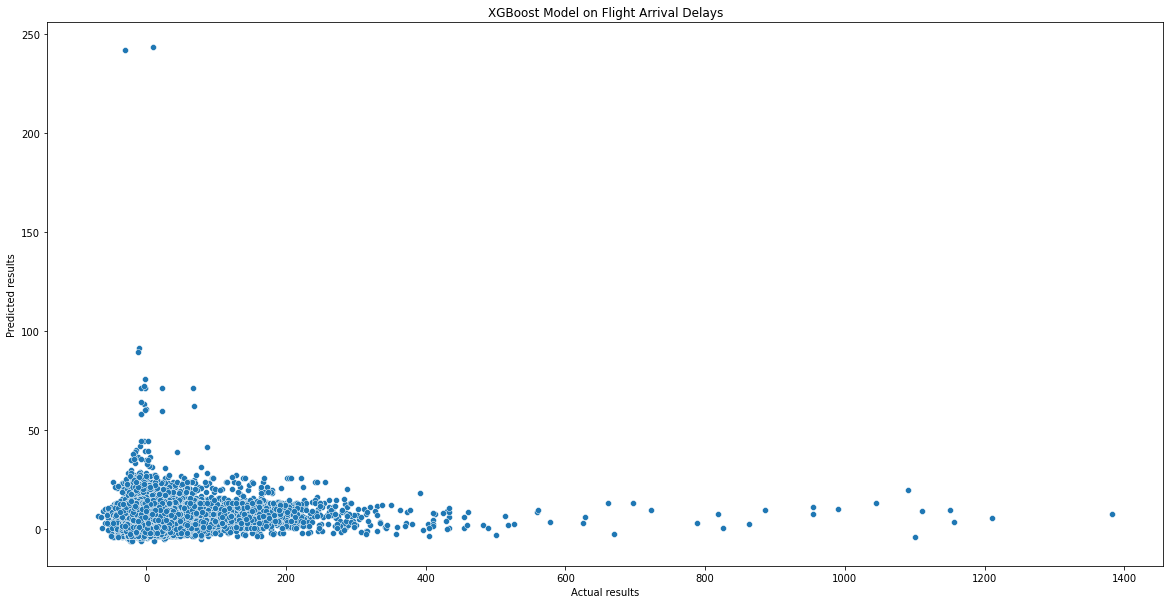

In [242]:
plt.figure(figsize=(20,10))
plt.xlabel('Actual results')
plt.ylabel('Predicted results')
plt.title('XGBoost Model on Flight Arrival Delays')
sns.scatterplot(x=y_test,y=y_pred)

# Sample Submission CSV Creation

In [243]:
flight_test_df

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance
0,2020-01-30,WN,2193,WN,N8642E,12191,HOU,"Houston, TX",13232,MDW,"Chicago, IL",1010,1235,145,937
1,2020-01-26,WN,3352,WN,N796SW,12992,LIT,"Little Rock, AR",15016,STL,"St. Louis, MO",1705,1810,65,296
2,2020-01-17,AS,365,AS,N584AS,14771,SFO,"San Francisco, CA",14057,PDX,"Portland, OR",2155,2344,109,550
3,2020-01-31,AA,3156,OO,N776SK,13930,ORD,"Chicago, IL",10372,ASE,"Aspen, CO",950,1214,204,1013
4,2020-01-25,WN,3762,WN,N8679A,14747,SEA,"Seattle, WA",13796,OAK,"Oakland, CA",1450,1655,125,672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2020-01-14,AA,5338,OH,N562NN,11057,CLT,"Charlotte, NC",11986,GRR,"Grand Rapids, MI",1622,1830,128,583
99996,2020-01-30,WN,2053,WN,N942WN,11292,DEN,"Denver, CO",15016,STL,"St. Louis, MO",2000,2255,115,770
99997,2020-01-06,WN,5757,WN,N923WN,14492,RDU,"Raleigh/Durham, NC",13204,MCO,"Orlando, FL",1730,1915,105,534
99998,2020-01-16,AA,1704,AA,N651AW,15304,TPA,"Tampa, FL",11057,CLT,"Charlotte, NC",813,1007,114,507


In [244]:
dep_hour = weather_time.obtain_depart_hour(flight_test_df)
arr_hour = weather_time.obtain_arrival_hour(flight_test_df)
flight_test_df['dep_hour'] = dep_hour
flight_test_df['arr_hour'] = arr_hour


In [245]:
flight_test_df['month'] = pd.to_datetime(flight_test_df['fl_date'],yearfirst=True).dt.month
flight_test_df['day'] = pd.to_datetime(flight_test_df['fl_date'],yearfirst=True).dt.day
flight_test_df['month'] = flight_test_df['month'].astype(int)
flight_test_df['dep_hour'] = flight_test_df['dep_hour'].astype(int)
flight_test_df['arr_hour'] = flight_test_df['arr_hour'].astype(int)

In [246]:
flight_test_model = flight_test_df[['crs_elapsed_time','distance','month','arr_hour','origin','dest','op_unique_carrier']]
flight_test_model

,crs_elapsed_time,distance,month,arr_hour,origin,dest,op_unique_carrier
0,145,937,1,12,HOU,MDW,WN
1,65,296,1,18,LIT,STL,WN
2,109,550,1,23,SFO,PDX,AS
3,204,1013,1,12,ORD,ASE,OO
4,125,672,1,16,SEA,OAK,WN
...,...,...,...,...,...,...,...
99995,128,583,1,18,CLT,GRR,OH
99996,115,770,1,22,DEN,STL,WN
99997,105,534,1,19,RDU,MCO,WN
99998,114,507,1,10,TPA,CLT,AA


In [247]:
transformed_data = one_hot.transform(flight_test_model[cat_cols])
encoded_data = pd.DataFrame(transformed_data, index=flight_test_model[cat_cols].index)
final_flight_test_model = pd.concat([flight_test_model,encoded_data],axis=1)
final_flight_test_model.drop(['origin','dest','op_unique_carrier'],axis=1,inplace=True)

In [249]:
unk_pred = xgboost.predict(final_flight_test_model)

In [256]:
og_features_flight_test = flight_test_df[['crs_elapsed_time','distance','month','arr_hour','origin','dest','op_unique_carrier']]

In [259]:
og_features_flight_test['target'] = unk_pred
og_features_flight_test.to_csv('data/sample_submission.csv')

C:\Users\John\AppData\Local\Temp\ipykernel_20108\3467597180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  og_features_flight_test['target'] = unk_pred
